# GP Homework: Balancing a pole on cart. 

### Goals
In this homework notebook, the goal is to evolve a genetic program that controls a cart with a pole attached to it by a passive joint. The pole is initially positioned at a random angle and with a random initial velocity (within some reasonable range). 

You can move the cart to the left or to the right with the same amount of force. This is represented, and transmitted as an action, in the simulation as a 0 (move left) or 1 (move right). In control systems lingo, this is called bang-bang control. Your goal is to balance the pole without letting it tilt too far in either direction by only moving the cart. 

The simulation of the cart will give you 4 bits of information in each step, the cart's position, the cart's velocity, the pole's angle, and the pole's velocity measured at it's highest point. You should probably create terminal nodes that take advantage of these in your evolved programs. 

### The Simulation
To get a physical simulation of the cart-pole problem and some nice visuals, we'll use the OpenAI Gym package. I'll walk through some of the details of this package here, but first we'll have to install it. The easiest way is to install it via `pip install gym` in the command line, but luckily Jupyter Notebooks provides a little trick to do this for us. If this comes back with an error, let me know and we'll try to get it resolved!


In [5]:
!pip install pygame

     |████████████████████████████████| 8.9 MB 13.6 MB/s eta 0:00:01     |█████████████████▊              | 4.9 MB 13.6 MB/s eta 0:00:01


In [6]:
!pip install gym

## Now let's play with the simulation environment!
This code will create the Cart-Pole environment and simulate it for 500 steps where each action is sampled randomly from the set of possible actions (`possible_actions`).

We'll also save the output of this simulation to a new folder "cartpole-results". This will save a detailed trace of each action, but also a little video of the cart and pole! If you turn this line off, the simulation will run without graphics and be **MUCH** faster (*hint: don't do this during evolution, but only when you want to inspect a particular evolved solution)*.

Note the 4 returns from the `env.step(action)` call. The four values I described in the Goals section are actually all within the first return, `observation`. We'll look a bit more into that in a second. 

In [19]:
import gym
from gym import wrappers
import random

#Setup the cart pole balancing problem
env = gym.make('CartPole-v0')

#This tells the environment to run for a max of 500 steps
#Less than 200 is probably too short, and more than 500 might
#be overkill, but I'm not really sure!
env._max_episode_steps = 500

#Push cart left, or push it right
possible_actions = [0,1]

#Reset the cart and pole with a random initial condition
#We can get all the info about the car and the pole from the
#observation variable and do something with it. But for now
#we'll just ignore it. 
observation = env.reset()

for i in range(500):
    #Pick a random action, and perform a step in the simulation
    action = random.choice(possible_actions)
    observation, reward, done, info = env.step(action)
    
    #show the environment, for funsies 
    env.render()
    
    
    #The simulation may tell us it's over before we've run all 500 steps
    #This often happens when the pole tilts too far!
    #For now, let's ignore it so we can watch the whole thing! 
    
    #if done:     
    #    break
    
env.close()

### Before we go look at that video, let's look into some of these variables.
`observation, reward, done, info = env.step(action)`
In case you haven't seen this notation before, it's just a quick way of unpacking multiple return values from a python function. In this case, most of the useful bits are wrapped up in `observation`. 

In this environment, `reward` returns 1 for each step, regardless of if that step was useful or not. Similarly, `info` is probably always empty, and `done` is 0 until the pole has tipped too far. These variables are more useful in other Gym environments and this package provides a consistent interface to simulation environments to make it easy to plug-and-play. 

### Let's look at what is in the last observation

In [11]:
print(observation)

[-0.03204726 -0.2481107   0.22197433  1.1391095 ]


# The documentation for this environment tells us what these values represent:

### Observation
Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -2.4 | 2.4
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -41.8&deg; | ~ 41.8&deg;
3 | Pole Velocity At Tip | -Inf | Inf

### Remember, these are probably the most useful values to use as variables in your genetic program!



<br>
<br>

# This is the code you've seen before in the GP worksheets. 
You shouldn't need to change any of this, but you might want to implement smarter mutation functions. That part of the code begins at Line 164.

In [20]:
import gym
from gym import wrappers
import numpy as np
from matplotlib import pyplot
import random

class GPNode:
    def __init__(self, node_type=None):
        self.parent = None
        self.node_type = node_type
        self.children = []
        self.depth = 0
        
    def add_child(self, child_node):
        child_node.depth = self.depth+1
        self.children.append(child_node)
        child_node.parent = self
    
    
class GPConstNode(GPNode):
    def __init__(self, value=None):
        super().__init__(node_type="Const")
        self.const_value = value
    
    def evaluate(self, input_state):
        return self.const_value
        
    def pretty_print(self, indents=0):
        print('  '*indents + str(self.const_value) 
              + ' : ' + str(self.depth))
        
    def deepcopy(self):
        new_node = GPConstNode(value=self.const_value)
        new_node.depth = self.depth;
        return new_node
        
        
class GPVariableNode(GPNode):
    def __init__(self, variable_name=None):
        super().__init__(node_type="Variable")
        self.variable_name = variable_name
    
    def evaluate(self, input_state):
        return input_state[self.variable_name]
    
    def pretty_print(self, indents=0):
        print('  '*indents + str(self.variable_name)
              + ' : ' + str(self.depth))
        
    def deepcopy(self):
        new_node = GPVariableNode(variable_name = self.variable_name)
        new_node.depth = self.depth
        return new_node
        
class GPFunctionNode(GPNode):
    def __init__(self, arg_count, func_name=None, gp_function=None):
        super().__init__(node_type="Function")
        self.argument_count = arg_count
        self.gp_function = gp_function
        self.function_name = func_name
        
    def evaluate(self, input_state): 
        assert self.argument_count == len(self.children), \
        'Number of child nodes must match argument count'

        child_results = [c.evaluate(input_state) for c in self.children]
        return self.gp_function(*child_results)

    def pretty_print(self, indents=0):
        print('  '*indents + str(self.function_name) 
              + ' : ' + str(self.depth))
        
        for child in self.children:
            child.pretty_print(indents+1)
        
    def deepcopy(self):
        new_node = GPFunctionNode(self.argument_count, 
                                   self.function_name, 
                                   self.gp_function)
        new_node.depth = self.depth
        
        for child in self.children:
            new_node.add_child(child.deepcopy())
        
        return new_node
class GPIndividual:
    # This is the beef of the individual code. We're growing random 
    # trees with a bit of extra sauce. 
    # We've defined a prob_terminal value that determines how 
    # likely it is that we select a terminal when choosing a random GP node. 
    # We're also limiting the depth of the trees we grow, because this is 
    # Python after all. 
    def grow_random(self, cur_node=None, cur_depth=0):
        if (random.random() < self.prob_terminal 
            or cur_depth == self.max_genotype_depth-1):
            new_node = random.choice(self.terminal_set).deepcopy()
            new_node.parent = cur_node
            new_node.depth = cur_depth
        else:
            new_node = random.choice(self.function_set).deepcopy()
            new_node.depth = cur_depth
            new_node.parent = cur_node
            for i in range(new_node.argument_count):
                new_node.add_child(self.grow_random(cur_node=new_node, 
                                                    cur_depth=cur_depth+1))
        return new_node
    
    
    # prob_terminal and max_depth have default parameters but you 
    # can use them to control how big the trees can get and how
    # likely you are to pick function/terminal nodes when growing
    # and mutating trees. 
    def __init__(self, function_set, terminal_set, 
                 prob_terminal=0.2, max_depth=5):
        self.max_genotype_depth = max_depth
        self.fitness = None
        self.function_set = function_set
        self.terminal_set = terminal_set
        self.prob_terminal = prob_terminal
        
        self.genotype = self.grow_random()
        
        
    def pretty_print(self):
        self.genotype.pretty_print()
        
        
    def deepcopy(self):
        new_individual = GPIndividual(self.function_set, 
                                      self.terminal_set, 
                                      self.prob_terminal, 
                                      self.max_genotype_depth)
        new_individual.genotype = self.genotype.deepcopy()
        return new_individual
    
    
    # This function just visits each node in the genome, growing
    # the list of nodes as it encounters children.
    def visit_genotype_nodes(self, cur_node=None):
        if cur_node == None: 
            cur_node = self.genotype
            
        node_list = [cur_node]
        visitor_index = 0
        
        while visitor_index < len(node_list):
            if len(node_list[visitor_index].children) > 0:
                node_list.extend(node_list[visitor_index].children)
            visitor_index += 1
            
        return node_list
        
    
    def evaluate(self, input_state):
        #evaluate the genotype
        individual_output = self.genotype.evaluate(input_state)
        if individual_output < 0:
            return 0
        else:
            return 1
    
    
    #TODO: You might want to implement a more clever mutation function!
    def mutate(self):
        # get a list of nodes...
        genotype_nodes = self.visit_genotype_nodes()
        # and pick one! 
        random_node = random.choice(genotype_nodes)
        
        if random_node.parent == None:
            #We've picked the root, so just grow a whole new genotype
            self.genotype = self.grow_random()
        else:
            #generate a new subtree using the random node's parent
            #as the parent for this subtree
            new_node = self.grow_random(random_node.parent, random_node.depth)
            #remove old node, add new node to parent's list of children
            random_node.parent.children.remove(random_node)
            random_node.parent.add_child(new_node)

            
class GPPopulation:
    def __init__(self, pop_size, function_set, terminal_set, max_depth, prob_terminal):
        self.pop_size = pop_size
        self.terminal_set = terminal_set
        self.function_set = function_set
        self.max_depth = max_depth
        self.prob_terminal = prob_terminal
        
        self.population = [GPIndividual(self.function_set, 
                                        self.terminal_set,
                                        self.prob_terminal, 
                                        self.max_depth) 
                           for _ in range(self.pop_size)]
        
        
    def update_fitnesses(self, fitness_function):
        fitnesses = []
        for individual in self.population:
            individual.fitness = fitness_function(individual)
            fitnesses.append(individual.fitness)
            
        return fitnesses
    
    
    def do_timestep(self, fitness_function, selection_function, mutation_prob):
        fitness_list = self.update_fitnesses(fitness_function)
        selected_individuals = [selection_function(self.population) 
                                for _ in range(self.pop_size)]
        
        for individual_idx in range(len(selected_individuals)):
            individual = selected_individuals[individual_idx].deepcopy()
            
            if random.random() < mutation_prob:
                individual.mutate()
            
            selected_individuals[individual_idx] = individual
        
        self.population = selected_individuals
        
        return fitness_list


## You'll want to add some more function nodes, and terminal nodes here


In [22]:
gp_add = GPFunctionNode(arg_count=2, func_name="Add", gp_function=lambda x, y: x+y)
gp_sub = GPFunctionNode(arg_count=2, func_name="Sub", gp_function=lambda x, y: x-y)

gp_const1 = GPConstNode(-42)
gp_const2 = GPConstNode(42)


gp_func_set = [gp_add, gp_sub]
gp_term_set = [gp_const1, gp_const2]

## This is probably where most of your attention will go. 
You should connect a genetic program individual to your cart balancing task, and figure out a way to assign a `fitness` to each individual! 

I've given you a function that creates the simulation environment and randomly picks an action, like before. It also returns a value of `1` for a fitness, which you should also change. 

The selection function is also rather simplistic. It just picks the best individual in the population. You probably should implement something like tournament selection or at least fitness proportional selection. 

In [23]:
def evlauate_cartpole_gp(individual):
    env = gym.make('CartPole-v0')
    env._max_episode_steps = 500
    observation = env.reset()
    for step_num in range(1000):
        
        #This is what you want to change:
        #Make your action the result of a genetic program evaluation!
        action = random.choice([0,1])
        
        observation, reward, done, info = env.step(action)
        if done: 
            break
    env.close()
    return 1


def my_fitness_function(gp_individual):
    return evlauate_cartpole_gp(gp_individual)

def my_selection_function(gp_population):    
    #pick max fitness individual
    winner_index = np.argmax([i.fitness for i in gp_population])
    return gp_population[winner_index]

# Once you've implemented the above functions, this code should work!
### I also just picked some random values for the population size, max_depth, etc., but feel free to experiment with those as well. 

In [24]:
mean_fitnesses = []

gp_pop = GPPopulation(pop_size=100, 
                      function_set=gp_func_set, 
                      terminal_set=gp_term_set,
                      max_depth=6,
                      prob_terminal=0.2)


for i in range(10):
    fitnesses = gp_pop.do_timestep(fitness_function=my_fitness_function, 
                   selection_function=my_selection_function,
                   mutation_prob=0.1)
    mean_fitnesses.append(np.mean(fitnesses))

/Users/zamanlh/opt/anaconda3/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


## And to make sure things are progressing, let's plot the mean fitness over time!

If your fitness function isn't working, you'll probably see a flat line.

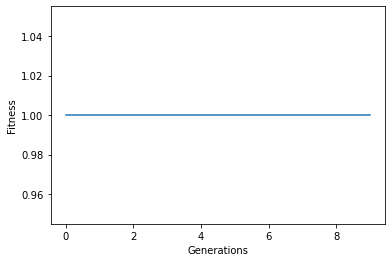

In [25]:
pyplot.plot(mean_fitnesses)
pyplot.xlabel("Generations")
pyplot.ylabel("Fitness")
pyplot.show()